In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/SI671_final_project/SI671_final_project/Data_file'

Mounted at /content/drive
/content/drive/Shared drives/SI671


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import matplotlib.pyplot as plt

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
data = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)

In [ ]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN


In [ ]:
data.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')

In [ ]:
data.shape

(1143860, 12)

In [ ]:
# Get percentage of missing values for each column
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
image,image,99.168605
vote,vote,86.169461
style,style,48.237896
reviewText,reviewText,0.034095
summary,summary,0.019146
reviewerName,reviewerName,0.012064
overall,overall,0.000000
verified,verified,0.000000
reviewTime,reviewTime,0.000000
reviewerID,reviewerID,0.000000


In [ ]:
# drop columns
drop_columns = ["style","image", "verified", "vote"]
data = data.drop(drop_columns,axis=1)

In [ ]:
data.shape

(1143860, 8)

In [ ]:
# Get percentage of missing values for each column
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
reviewText,reviewText,0.034095
summary,summary,0.019146
reviewerName,reviewerName,0.012064
overall,overall,0.000000
reviewTime,reviewTime,0.000000
reviewerID,reviewerID,0.000000
asin,asin,0.000000
unixReviewTime,unixReviewTime,0.000000


In [ ]:
# drop rows that have missing values on reviewtext and summary
data = data.dropna(subset=['reviewText', 'summary',"reviewerName"])

In [ ]:
# check the percentage again
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
overall,overall,0.0
reviewTime,reviewTime,0.0
reviewerID,reviewerID,0.0
asin,asin,0.0
reviewerName,reviewerName,0.0
reviewText,reviewText,0.0
summary,summary,0.0
unixReviewTime,unixReviewTime,0.0


In [ ]:
data.shape

(1143155, 8)

### Product based CF

In [ ]:
data.head()

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200
1,5,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800
2,5,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000
3,5,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600
4,5,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200


In [ ]:
count = data.groupby("asin", as_index=False).count()

# return the mean overall grade for products
mean = data.groupby("asin", as_index=False).mean()

In [ ]:
count.head()

,asin,overall,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime
0,4639725043,30,30,30,30,30,30,30
1,4639725183,12,12,12,12,12,12,12
2,5463213682,9,9,9,9,9,9,9
3,9742356831,96,96,96,96,96,96,96
4,B00004S1C5,14,14,14,14,14,14,14


In [ ]:
dataMerged = pd.merge(data, count, how="right", on=["asin"])
dataMerged.head()

,overall_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,overall_y,reviewTime_y,reviewerID_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y
0,5,"04 29, 2012",A1J205ZK25TZ6W,4639725043,kez panel project,I make the best brewed iced tea with this yell...,Best for brewed iced tea.,1335657600,30,30,30,30,30,30,30
1,3,"04 11, 2008",ACOICLIJQYECU,4639725043,N D,I have recently started drinking hot tea again...,Not Bad for iced Tea,1207872000,30,30,30,30,30,30,30
2,5,"03 15, 2017",A29RCQA5G0B1BA,4639725043,Edward Pendleton,I like pretty much all of Lipton's tea... I ju...,A Great Cuppa...!,1489536000,30,30,30,30,30,30,30
3,5,"03 4, 2017",A34KF6WKUMO0G5,4639725043,Kindle Customer,I was watching a youtube video about buying te...,Strong for this American,1488585600,30,30,30,30,30,30,30
4,3,"02 27, 2017",A2AW00VDYVKKKK,4639725043,Lou S. Hegwer,"it was ok, but it didn't taste like the Lipton...",not the same,1488153600,30,30,30,30,30,30,30


In [ ]:
#rename column
dataMerged["totalReviewers"] = dataMerged["reviewerID_y"]
dataMerged["overallScore"] = dataMerged["overall_x"]
dataMerged["summaryReview"] = dataMerged["summary_x"]

dataNew = dataMerged[["asin", "summaryReview", "overallScore", "totalReviewers"]]

In [ ]:
dataNew.head()

,asin,summaryReview,overallScore,totalReviewers
0,4639725043,Best for brewed iced tea.,5,30
1,4639725043,Not Bad for iced Tea,3,30
2,4639725043,A Great Cuppa...!,5,30
3,4639725043,Strong for this American,5,30
4,4639725043,not the same,3,30


In [ ]:
dataNew.shape

(1143155, 4)

In [ ]:
# filter products that have more than 100 reviews
dataMerged = dataMerged.sort_values(by="totalReviewers",ascending=False)
dataCount = dataMerged[dataMerged.totalReviewers>=100]

### Grouping all the summary Reviews by product ID

In [ ]:
#dataProductReview = data.groupby("asin",as_index=False)
ProductReviewSummary = dataCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)

In [ ]:
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [ ]:
mean.head()

,asin,overall,unixReviewTime
0,4639725043,4.200000,1.421277e+09
1,4639725183,4.833333,1.436609e+09
2,5463213682,4.888889,1.443235e+09
3,9742356831,4.552083,1.436860e+09
4,B00004S1C5,4.000000,1.351160e+09


### create dataframe with certain columns

In [ ]:
data3 = pd.merge(ProductReviewSummary, mean, on="asin",how="inner")

In [ ]:
data3.head()

,asin,summaryReview,overall,unixReviewTime
0,B00008RCN8,"[I chew too much, Orbit's the Best!, Favorite ...",4.466292,1.435446e+09
1,B0000CFPI2,"[Five Stars, This flavor rocks, Five Stars, EL...",4.560386,1.430755e+09
2,B0000D9169,[My local Publix Supermarket has better cookie...,4.477528,1.486752e+09
3,B0000D916Y,"[Five Stars, Five Stars, Pretty good, Excellen...",4.477528,1.486752e+09
4,B0000DHXGL,"[These ""First to Live ALMONDS."" are ""Top Quali...",4.352349,1.446733e+09


In [ ]:
data3 = data3[["asin","summaryReview","overall"]]

### Text cleaning - Summary Column

In [ ]:
# function for tokenizing summary
regEx = re.compile("[^a-z]+")
def cleanReviews(reviewText):
  for i in range(len(reviewText)):
    reviewText[i] = reviewText[i].lower()
    reviewText[i] = regEx.sub(" ", reviewText[i]).strip()
  return reviewText 

In [ ]:
data3.shape

(1824, 3)

In [ ]:
# reset index and drop duplicate rows
data3["summaryClean"] = data3["summaryReview"].apply(cleanReviews)
data3 = data3.drop_duplicates(["overall"], keep="last")
data3 = data3.reset_index()

In [ ]:
data3.shape

(1626, 5)

In [ ]:
data3.head()

,index,asin,summaryReview,overall,summaryClean
0,0,B00008RCN8,"[i chew too much, orbit s the best, favorite f...",4.466292,"[i chew too much, orbit s the best, favorite f..."
1,1,B0000CFPI2,"[five stars, this flavor rocks, five stars, el...",4.560386,"[five stars, this flavor rocks, five stars, el..."
2,3,B0000D916Y,"[five stars, five stars, pretty good, excellen...",4.477528,"[five stars, five stars, pretty good, excellen..."
3,4,B0000DHXGL,[these first to live almonds are top quality n...,4.352349,[these first to live almonds are top quality n...
4,5,B0000DI145,"[love this tea, like this tea sweetened with s...",4.503906,"[love this tea, like this tea sweetened with s..."


In [ ]:
reviews = data3["summaryClean"].apply(lambda x:" ".join(x))
#dataReviews = pd.DataFrame(transformedReviews.A)

In [ ]:
reviews

0       i chew too much orbit s the best favorite flav...
1       five stars this flavor rocks five stars elimin...
2       five stars five stars pretty good excellent gr...
3       these first to live almonds are top quality nu...
4       love this tea like this tea sweetened with ste...
                              ...                        
1621    i do like having an alternative to peanut butt...
1622    if you like amonds buy these excellent quality...
1623    i love this product yum great flavor beefy tas...
1624    dissolves well convenient and good instant cof...
1625    wonderful flavor great quality one star no non...
Name: summaryClean, Length: 1626, dtype: object

In [ ]:
countVector = CountVectorizer(max_features=300,stop_words="english")
transformedReviews = countVector.fit_transform(reviews)

In [ ]:
dataReviews = pd.DataFrame(transformedReviews.A, columns=countVector.get_feature_names())

In [ ]:
dataReviews = dataReviews.astype(int)

In [ ]:
dataReviews.head()

,absolutely,add,added,addictive,aftertaste,almond,almonds,alternative,amazing,amazon,apple,arrived,awesome,bad,bag,bags,baking,bar,bars,beans,best,better,big,bit,bitter,black,bland,blend,bob,bold,bought,box,brand,bread,breakfast,butter,buy,buying,calories,candy,...,tastes,tasting,tasty,tea,teas,terrible,texture,thank,thing,think,thought,time,treat,tried,try,use,used,using,value,vanilla,variety,ve,want,water,way,weak,white,wish,won,wonderful,work,works,worth,wow,wrong,years,yes,yuck,yum,yummy
0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,9,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,...,2,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,5,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,5
1,1,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,13,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2,1,0,0,...,6,3,4,0,0,0,0,0,1,2,0,1,0,0,0,5,2,1,0,0,1,0,0,0,0,0,0,0,0,0,1,6,1,0,0,0,0,0,1,7
2,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,11,4,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,1,3,0,0,0,0,0,0,0,0,1,2,0,2,0,0,0,0,0,1,2,0,0,1,0,0,0,0,3,0,0,2,1,0,1,0,0,0,11
3,1,0,0,0,0,12,54,0,1,0,0,0,1,4,2,0,0,0,0,0,12,1,1,0,2,0,0,0,0,0,1,0,1,0,1,0,5,1,0,0,...,1,3,0,1,0,0,1,1,1,0,0,1,0,0,1,1,2,0,2,0,0,2,0,0,0,0,0,0,1,3,0,0,1,0,0,0,0,1,2,6
4,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,11,3,1,0,2,2,0,0,0,0,0,0,0,0,1,0,1,1,0,0,...,5,2,6,87,2,0,0,0,0,0,0,3,0,0,1,1,0,0,1,0,0,1,0,3,1,0,0,0,0,4,0,1,1,0,0,0,0,0,2,4


In [ ]:
# save the file
dataReviews.to_csv("dataReviews.csv")

In [ ]:
# First let's create a dataset called x
x = np.array(dataReviews)

# create train and test
tpercent = 0.8
tsize = int(np.floor(tpercent*len(dataReviews)))
dataReviews_train = x[:tsize]
dataReviews_test = x[tsize:]

# len of train and test
lentrain = len(dataReviews_train)
lentest = len(dataReviews_test)

In [ ]:
print(lentrain)
print(lentest)

1300
326


In [ ]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm="ball_tree").fit(dataReviews_train)

# let's find the k-neighbors of each point in object x. 
# To do that we call the kneighbors() function on object x
distances, indices = neighbor.kneighbors(dataReviews_train)

In [ ]:
# find most related products
for i in range(lentest):
  a = neighbor.kneighbors([dataReviews_test[i]])
  related_product_list = a[1]

  first_related_product = [item[0] for item in related_product_list][0]
  second_related_product = [item[1] for item in related_product_list][0]

  print("Based on product reviews, for ", 
        data3["asin"][lentrain+i], 
        " average rating is ", data3["overall"][lentrain+i])
  print("The first similar product is ", data3["asin"][first_related_product],
        " average rating is ", data3["overall"][first_related_product])
  print("The second similar product is ", data3["asin"][second_related_product],
        " average rating is ", data3["overall"][second_related_product])
  print("=================================================================")

Based on product reviews, for  B00GRNUJYQ  average rating is  4.066921606118547
The first similar product is  B007PA34CE  average rating is  4.619658119658119
The second similar product is  B0029XLH4Y  average rating is  4.548654244306419
Based on product reviews, for  B00GRY2Z5Q  average rating is  4.296551724137931
The first similar product is  B007BIUB62  average rating is  4.1946902654867255
The second similar product is  B0019LTH3U  average rating is  4.590551181102362
Based on product reviews, for  B00GRY33AC  average rating is  4.49685534591195
The first similar product is  B000M56BS8  average rating is  4.739726027397261
The second similar product is  B0009P68KM  average rating is  4.7637795275590555
Based on product reviews, for  B00GWLK8LM  average rating is  4.584745762711864
The first similar product is  B00GCZBZBA  average rating is  4.5271317829457365
The second similar product is  B0000EWY28  average rating is  4.5181818181818185
Based on product reviews, for  B00GZJMR9W

### Predicting Review Score

In [ ]:
data5_train_target = data3["overall"][:lentrain]
data5_test_target = data3["overall"][lentrain:lentrain+lentest]
data5_train_target = data5_train_target.astype(int)
data5_test_target = data5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors,weights="distance")
knnclf.fit(dataReviews_train, data5_train_target)
knnpreds_test = knnclf.predict(dataReviews_test)

print(classification_report(data5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.12      0.22        24
           4       0.93      1.00      0.97       302

    accuracy                           0.94       326
   macro avg       0.97      0.56      0.59       326
weighted avg       0.94      0.94      0.91       326



### Accuracy of the model

In [ ]:
print(accuracy_score(data5_test_target, knnpreds_test))

0.9355828220858896


In [ ]:
print(mean_squared_error(data5_test_target,knnpreds_test))

0.06441717791411043


### Predicting Review Score with k = 5

In [ ]:
data5_train_target = data3["overall"][:lentrain]
data5_test_target = data3["overall"][lentrain:lentrain+lentest]
data5_train_target = data5_train_target.astype(int)
data5_test_target = data5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors,weights="distance")
knnclf.fit(dataReviews_train, data5_train_target)
knnpreds_test = knnclf.predict(dataReviews_test)

print(classification_report(data5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.08      0.15        24
           4       0.93      1.00      0.96       302

    accuracy                           0.93       326
   macro avg       0.97      0.54      0.56       326
weighted avg       0.94      0.93      0.91       326



In [ ]:
print(accuracy_score(data5_test_target, knnpreds_test))

0.9325153374233128


In [ ]:
print(mean_squared_error(data5_test_target,knnpreds_test))

0.06748466257668712


### KNN with k=3, Algorithm = Brute

In [ ]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm="brute").fit(dataReviews_train)

distances, indices = neighbor.kneighbors(dataReviews_train)

In [ ]:
data5_train_target = data3["overall"][:lentrain]
data5_test_target = data3["overall"][lentrain:lentrain+lentest]
data5_train_target = data5_train_target.astype(int)
data5_test_target = data5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors,weights="distance")
knnclf.fit(dataReviews_train, data5_train_target)
knnpreds_test = knnclf.predict(dataReviews_test)

print(classification_report(data5_test_target, knnpreds_test))
print("Accuracy: ",accuracy_score(data5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(data5_test_target,knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.12      0.22        24
           4       0.93      1.00      0.97       302

    accuracy                           0.94       326
   macro avg       0.97      0.56      0.59       326
weighted avg       0.94      0.94      0.91       326

Accuracy:  0.9355828220858896
MSE:  0.06441717791411043


### KNN with k = 3, Algorithm = KD_Tree

In [ ]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm="kd_tree").fit(dataReviews_train)

distances, indices = neighbor.kneighbors(dataReviews_train)

In [ ]:
data5_train_target = data3["overall"][:lentrain]
data5_test_target = data3["overall"][lentrain:lentrain+lentest]
data5_train_target = data5_train_target.astype(int)
data5_test_target = data5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors,weights="distance")
knnclf.fit(dataReviews_train, data5_train_target)
knnpreds_test = knnclf.predict(dataReviews_test)

print(classification_report(data5_test_target, knnpreds_test))
print("Accuracy: ",accuracy_score(data5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(data5_test_target,knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.12      0.22        24
           4       0.93      1.00      0.97       302

    accuracy                           0.94       326
   macro avg       0.97      0.56      0.59       326
weighted avg       0.94      0.94      0.91       326

Accuracy:  0.9355828220858896
MSE:  0.06441717791411043


### Word correlation based on cluster

In [ ]:
cluster = data.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)

In [ ]:
cluster.to_csv("cluster.csv")

In [ ]:
cluster["summaryClean"] = cluster["summary"].apply(cleanReviews)

In [ ]:
cluster["summaryClean"] = cluster["summaryClean"].apply(lambda x: " ".join(x))

In [ ]:
cluster

,summary,summaryClean
overall,,
1,"[does not look anything like tea, disappointed...",does not look anything like tea disappointed c...
2,"[tastes ok if you can stand the heat, too much...",tastes ok if you can stand the heat too much r...
3,"[not bad for iced tea, not the same, the tea i...",not bad for iced tea not the same the tea is w...
4,"[four stars, well i bought this tea after bein...",four stars well i bought this tea after being ...
5,"[five stars, great product, strong, great tea,...",five stars great product strong great tea this...


### Word Clouding for each score group

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title=None):
  wordcloud = WordCloud(background_color="white",stopwords=stopwords,
                        max_words=500,max_font_size=30,scale=3,
                        random_state=1).generate(str(data))
  fig = plt.figure(1, figsize=(8,8))
  plt.axis("off")
  if title:
    fig.suptitle(title,fontsize=20)
    fig.subplots_adjust(top=2.3)

  plt.imshow(wordcloud)
  plt.show()

In [ ]:
cluster["summaryClean"][1]

'does not look anything like tea disappointed contains shrimp not natural organic at all poor quality poor ingredients late outdated months late dirty salt glass and rocks not for my taste don t get excited by these the section of the no dates on the product not nearly as pretty as they look garish colors real crap all broken is this different manufacturer one star one star the expiry date is jan i disappointed with the flavor goes tasteless so quick one star bleh one star the bottle was busted only a couple of pieces you can t blow bubbles with it why is the picture showing the pack no good not whitening ok tastes like scorched garbage one star plastic flakes for dessert not sparkly do not buy disappointed these are only ounce bottles i thought this don t be fooled it tastes like cream of wheat not oatmeal don t buy them for one jar of peanut butter really good pizza seasoning long time favorite but wait uh oh gross i never understood the appeal it is not good for use on cookies terri

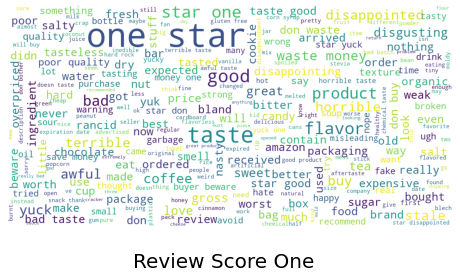

In [ ]:
show_wordcloud(cluster["summaryClean"][1],title="Review Score One")

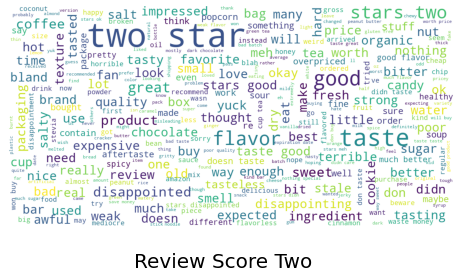

In [ ]:
show_wordcloud(cluster["summaryClean"][2],title="Review Score Two")

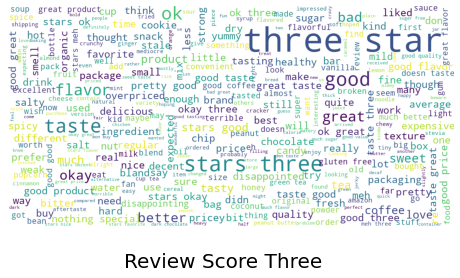

In [ ]:
show_wordcloud(cluster["summaryClean"][3],title="Review Score Three")

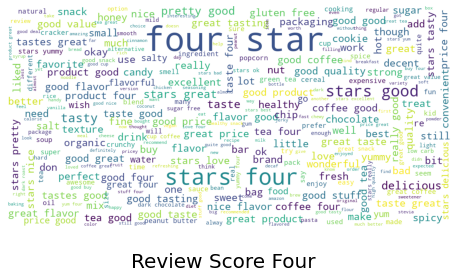

In [ ]:
show_wordcloud(cluster["summaryClean"][4],title="Review Score Four")

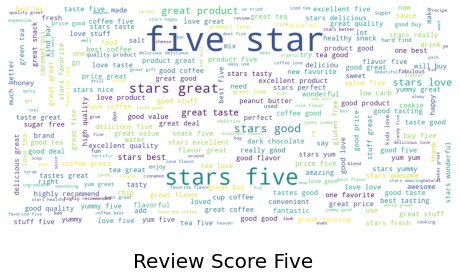

In [ ]:
show_wordcloud(cluster["summaryClean"][5],title="Review Score Five")